<div style="width:100%; background-color: #D9EDF7; border: 1px solid #CFCFCF; text-align: left; padding: 10px;">
      <b>Conventional Power Plants: Power Plants in Germany</b>
      <ul>
        <li><a href="main.ipynb">Main Notebook</a></li>
        <li>Processing notebook for German power plant</li>
        <li><a href="download_and_process_EU.ipynb">Processing notebook for European power plants</a></li>
      </ul>
      <br>This notebook is part of the <a href="http://data.open-power-system-data.org/DATA PACKAGE NAME HERE"> Data package name here Data Package</a> of <a href="http://open-power-system-data.org">Open Power System Data</a>.
</div>

# 1. Power Plants in Germany

This file covers german power plants. It downloads the power plant list from the German Federal Network Agency (BNetzA) and augments it with more information.

## Table of Contents
* [1. Power Plants in Germany](#1.-Power-Plants-in-Germany)
* [2. Prepare the environment](#2.-Prepare-the-environment)
* [3. Download settings](#3.-Download-settings)
	* [3.1 Choose download location](#3.1-Choose-download-location)
* [4. Define functions](#4.-Define-functions)
* [5. Downloads](#5.-Downloads)
	* [5.1 Download the BNetzA power plant list](#5.1-Download-the-BNetzA-power-plant-list)
	* [5.2 Download the Uba Plant list](#5.2-Download-the-Uba-Plant-list)
* [6. Translate contents](#6.-Translate-contents)
	* [6.1 Columns](#6.1-Columns)
	* [6.2 Fuel types](#6.2-Fuel-types)
	* [6.3 Power plant status](#6.3-Power-plant-status)
	* [6.4 CHP Capability](#6.4-CHP-Capability)
	* [6.5 EEG](#6.5-EEG)
	* [6.6 UBA Columns](#6.6-UBA-Columns)
* [7. Process data](#7.-Process-data)
	* [7.1 Set index to the BNetzA power plant ID](#7.1-Set-index-to-the-BNetzA-power-plant-ID)
	* [7.2 Merge data from UBA List](#7.2-Merge-data-from-UBA-List)
		* [7.2.1 case 1-1](#7.2.1-case-1-1)
		* [7.2.2 case n-1](#7.2.2-case-n-1)
		* [7.2.3 case 1-n](#7.2.3-case-1-n)
		* [7.2.4 Merge into plantlist](#7.2.4-Merge-into-plantlist)
	* [7.3 Delete fuels not in focus](#7.3-Delete-fuels-not-in-focus)
	* [7.4 Add Columns for shutdown and retrofit](#7.4-Add-Columns-for-shutdown-and-retrofit)
	* [7.5 Convert input colums to usable data types](#7.5-Convert-input-colums-to-usable-data-types)
	* [7.6 Identify generation technology](#7.6-Identify-generation-technology)
		* [7.6.1 Process technology information from UBA list](#7.6.1-Process-technology-information-from-UBA-list)
		* [7.6.2 Identify generation technology based on BNetzA information](#7.6.2-Identify-generation-technology-based-on-BNetzA-information)
	* [7.7 Add country code](#7.7-Add-country-code)
	* [7.8 Add efficiency data](#7.8-Add-efficiency-data)
		* [7.8.1 Efficiencies from research](#7.8.1-Efficiencies-from-research)
			* [7.8.1.1 Import data](#7.8.1.1-Import-data)
			* [7.8.1.2 Plot efficiencies by year of commissioning](#7.8.1.2-Plot-efficiencies-by-year-of-commissioning)
			* [7.8.1.3 Determine least-squares approximation based on researched data (planned)](#7.8.1.3-Determine-least-squares-approximation-based-on-researched-data-%28planned%29)
			* [7.8.1.4 Apply efficiency approximation from least squares approximation (planned)](#7.8.1.4-Apply-efficiency-approximation-from-least-squares-approximation-%28planned%29)
		* [7.8.2 Efficiencies from literature](#7.8.2-Efficiencies-from-literature)
			* [7.8.2.1 Import data](#7.8.2.1-Import-data)
			* [7.8.2.2 Apply efficiency approximation from literature](#7.8.2.2-Apply-efficiency-approximation-from-literature)
	* [7.9 Add geodata](#7.9-Add-geodata)
	* [7.10 Allocate energy source levels](#7.10-Allocate-energy-source-levels)
* [8. Define final output](#8.-Define-final-output)
	* [8.1 Round values](#8.1-Round-values)
	* [8.2 Verification](#8.2-Verification)
		* [8.2.1 Capacities by plant status](#8.2.1-Capacities-by-plant-status)
		* [8.2.2 Power plant age](#8.2.2-Power-plant-age)
		* [8.2.3 Block size vs year of commissioning](#8.2.3-Block-size-vs-year-of-commissioning)
	* [8.3 Logical checks](#8.3-Logical-checks)
		* [8.3.1 Every power plant needs a capacity](#8.3.1-Every-power-plant-needs-a-capacity)
		* [8.3.2 Commissioning Dates](#8.3.2-Commissioning-Dates)
		* [8.3.3 Compare UBA and BNetzA data](#8.3.3-Compare-UBA-and-BNetzA-data)
			* [8.3.3.1 Postcodes of BNetzA and UBA lists should match](#8.3.3.1-Postcodes-of-BNetzA-and-UBA-lists-should-match)
			* [8.3.3.2 Compare Installed capacities](#8.3.3.2-Compare-Installed-capacities)
* [9. Result export](#10.-Result-export)

# 2. Prepare the environment

In [147]:
# Import all functions from external file
from download_and_process_DE_functions import *

# Jupyter functions
%matplotlib inline

# 3. Download settings

## 3.1 Choose download location

The original data can either be downloaded from the original data sources as specified below or from the opsd-Server. Default option is to download from the original sources as the aim of the project is to stay as close to original sources as possible. However, if problems with downloads e.g. due to changing urls occur, you can still run the script with the original data from the opsd_server.

In [148]:
download_from = 'original_sources'
#download_from = 'opsd_server' 

In [149]:
if download_from == 'original_sources':
    # BNetzA Power plant list
    url_bnetza = ('http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/'
              'Sachgebiete/Energie/Unternehmen_Institutionen/Versorgungssicherheit/'
              'Erzeugungskapazitaeten/Kraftwerksliste/Kraftwerksliste_CSV.csv'
              '?__blob=publicationFile&v=10')

    # UBA Power plant list
    url_uba = ('https://www.umweltbundesamt.de/sites/default/files/medien/'
               '372/dokumente/kraftwerke_de_ab_100_mw_0.xls')


In [150]:
if download_from == 'opsd_server':
    # Specify direction to original_data folder on the opsd data server
    # BNetzA Power plant list
    url_bnetza = 'http://data.open-power-system-data.org/conventional_power_plants/'
    url_bnetza = url_bnetza + '2020-10-01'
    url_bnetza = url_bnetza +'/original_data/Kraftwerksliste_CSV.csv'
    
    # UBA Power plant list
    url_uba = 'http://data.open-power-system-data.org/conventional_power_plants/'
    url_uba = url_uba + '2020-10-01'
    url_uba = url_uba +'/original_data/kraftwerke-de-ab-100-mw_0.xls'

# 4. Define functions

Functions used multiple times within this script are now located in a separate file called download_and_process_DE_functions.py

# 5. Downloads

## 5.1 Download the BNetzA power plant list

This section downloads the BNetzA power plant list and converts it to a pandas data frame

In [151]:
plantlist = getbnetzalist(url_bnetza)

# clean unnamed columns
plantlist.drop([c for c in plantlist.columns if 'Unnamed:' in c], axis=1, inplace=True)

plantlist.head()

01 Oct 2020 12:22:40 - root - INFO - Using local file from download\2020-10-1-Kraftwerksliste_CSV.csv


,Kraftwerksnummer Bundesnetzagentur,Unternehmen,Kraftwerksname,PLZ\n(Standort Kraftwerk),Ort\n(Standort Kraftwerk),Straße und Hausnummer (Standort Kraftwerk),Bundesland,Blockname,Datum der Aufnahme der kommerziellen Stromeinspeisung der Erzeugungseinheit [Datum/jahr],Kraftwerksstatus \n(in Betrieb/\nvorläufig stillgelegt/\nsaisonale Konservierung\nReservekraftwerk/\nSonderfall),Energieträger,"Spezifizierung ""Mehrere Energieträger"" und ""Sonstige Energieträger"" - Hauptbrennstoff","Spezifizierung ""Mehrere Energieträger"" - Zusatz- / Ersatzbrennstoffe",Auswertung\nEnergieträger (Zuordnung zu einem Hauptenergieträger bei Mehreren Energieträgern),Förderberechtigt nach EEG\n(ja/nein),Wärmeauskopplung (KWK)\n(ja/nein),Netto-Nennleistung (elektrische Wirkleistung) in MW,Bezeichnung Verknüpfungspunkt (Schaltanlage) mit dem Stromnetz der Allgemeinen Versorgung gemäß Netzbetreiber,Netz- oder Umspannebene des Anschlusses,Name Stromnetzbetreiber
0,BNA0001,NaN,NaN,52074,Aachen,NaN,Nordrhein-Westfalen,NaN,1997,in Betrieb,Windenergie (Onshore-Anlage),NaN,NaN,Windenergie (Onshore-Anlage),Ja,NaN,15.0,NaN,Mittelspannung (MS),INFRAWEST GmbH
1,BNA1888,STAWAG Energie GmbH,Windpark Aachen Nord GmbH & Co. KG,NaN,Aachen,NaN,Nordrhein-Westfalen,NaN,08.06.2017,in Betrieb,Windenergie (Onshore-Anlage),NaN,NaN,Windenergie (Onshore-Anlage),Ja,NaN,12.1,NaN,NaN,NaN
2,BNA1011,Breeze Three Energy GmbH & Co. KG,Windpark Waldhausen,73433,Aalen,NaN,Baden-Württemberg,NaN,30.12.2006,in Betrieb,Windenergie (Onshore-Anlage),NaN,NaN,Windenergie (Onshore-Anlage),Ja,Nein,14.0,DE0010107343300000000000000287689 & DE 0010107...,Mittelspannung (MS),Netzgesellschaft Ostwürttemberg DonauRies GmbH
3,BNA1938,Papierfabrik Palm GmbH & Co. KG,KWK-Anlage Neukochen,73432,Aalen,NaN,Baden-Württemberg,Neukochen 10,01.01.1960,in Betrieb,Erdgas,NaN,NaN,Erdgas,Nein,Ja,15.0,UW Erlau,Mittelspannung (MS),Stadtwerke Aalen
4,BNA0002,ecoJoule construct GmbH,NaN,28832,Achim,NaN,Niedersachsen,NaN,2002,in Betrieb,Windenergie (Onshore-Anlage),NaN,NaN,Windenergie (Onshore-Anlage),Ja,NaN,13.3,NaN,USp. Hoch- / Mittelspannung (HS/MS),EWE NETZ GmbH


## 5.2 Download the UBA Plant list

This section downloads the power plant list from the German Federal Environment Agency (UBA) and converts it to a pandas data frame.

In [152]:
plantlist_uba = getubalist(url_uba)
plantlist_uba.head()

01 Oct 2020 12:22:40 - root - INFO - Using local file from download\2020-10-1-kraftwerke_de_ab_100_mw_0.xls


,Kraftwerksname / Standort,Betreiber,Bundesland,Standort-PLZ,Kraftwerksstandort,Elektrische Bruttoleistung (MW),Fernwärme-leistung (MW),Inbetriebnahme (ggf. Ertüchtigung),Anlagenart,Primärenergieträger
0,Albatros,EnBW Albatros GmbH & Co. KG / Enbridge Inc.,Offshore,NaN,Nordsee,112.0,NaN,2019,WEA,Wind (O)
1,Albbruck-Dogern,Rheinkraftwerk Albbruck-Dogern AG / RWE Vertri...,BW,79774.0,Albbruck,108.9,NaN,1933 / 2009 (2020),LWK,Wasser
2,"Altbach/Deizisau GT A-C, E",EnBW Kraftwerke AG,BW,73776.0,Altbach,305.0,NaN,1971-1997,GT,Erdgas
3,Altbach/Deizisau HKW 1,EnBW Kraftwerke AG,BW,73776.0,Altbach,476.0,280,1985 (2006),HKW,Steinkohle
4,Altbach/Deizisau HKW 2,EnBW Kraftwerke AG,BW,73776.0,Altbach,379.0,280,1997 (2012),HKW (DT),Steinkohle


# 6. Translate contents

## 6.1 BNetzA Columns

A dictionary with the original column names to the new column names is created. This dictionary is used to translate the column names.

In [153]:
dict_columns = {
    'Kraftwerksnummer Bundesnetzagentur':
        'id',
    'Unternehmen':
        'company',
    'Kraftwerksname':
        'name',
    'PLZ\n(Standort Kraftwerk)':
        'postcode',
    'Ort\n(Standort Kraftwerk)':
        'city',
    'Straße und Hausnummer (Standort Kraftwerk)':
        'street',
    'Bundesland':
        'state',
    'Blockname':
        'block',
    ('Datum der Aufnahme der kommerziellen Stromeinspeisung der Erzeugungseinheit [Datum/jahr]'):
        'commissioned',
    ('Kraftwerksstatus \n(in Betrieb/\nvorläufig stillgelegt/\nsaisonale '
     'Konservierung\nReservekraftwerk/\nSonderfall)'):
        'status',
    ('Kraftwerksstatus \n(in Betrieb/\nvorläufig stillgelegt/\nsaisonale '
     'Konservierung\nGesetzlich an Stilllegung gehindert/\nSonderfall)'):
        'status',
    ('Kraftwerksstatus \n(in Betrieb/\nvorläufig stillgelegt/\nsaisonale '
     'Konservierung\nNetzreserve/ Sicherheitsbereitschaft/\nSonderfall)'):
        'status',
    'Energieträger':
        'fuel_basis',
    ('Spezifizierung "Mehrere Energieträger" und "Sonstige Energieträger" - '
     'Hauptbrennstoff'): 'fuel_multiple1',
    'Spezifizierung "Mehrere Energieträger" - Zusatz- / Ersatzbrennstoffe':
        'fuel_multiple2',
    ('Auswertung\nEnergieträger (Zuordnung zu einem Hauptenergieträger bei '
     'Mehreren Energieträgern)'):
        'fuel',
    'Förderberechtigt nach EEG\n(ja/nein)':
        'eeg',
    'Wärmeauskopplung (KWK)\n(ja/nein)':
        'chp',
    'Netto-Nennleistung (elektrische Wirkleistung) in MW':
        'capacity',
    ('Bezeichnung Verknüpfungspunkt (Schaltanlage) mit dem Stromnetz der '
     'Allgemeinen Versorgung gemäß Netzbetreiber'):
        'network_node',
    'Netz- oder Umspannebene des Anschlusses':
        'voltage',
    'Name Stromnetzbetreiber':
        'network_operator',
    'Kraftwerksname / Standort':
        'uba_name',
    'Betreiber ':
        'uba_company',
    'Standort-PLZ':
        'uba_postcode',
    'Kraftwerksstandort':
        'uba_city',
    'Elektrische Bruttoleistung (MW)':
        'uba_capacity',
    'Fernwärme-leistung (MW)':
        'uba_chp_capacity',
    'Inbetriebnahme  (ggf. Ertüchtigung)':
        'uba_commissioned',
    'Anlagenart':
        'uba_technology',
    'Primärenergieträger':
        'uba_fuel',
}
plantlist.rename(columns=dict_columns, inplace=True)

# Check if all columns have been translated
for columnnames in plantlist.columns:
    # if columnnames not in dict_columns.values():
    if columnnames not in dict_columns.values():
        logger.error("Untranslated column: "+ columnnames)


## 6.2 Fuel types

In [154]:
# first remove line breaks
plantlist['fuel'] = plantlist['fuel'].str.replace('\n', ' ')

# Delete entries without fuel and name
plantlist = plantlist.dropna(subset = ['fuel','name'])

dict_fuels = {
    'Steinkohle': 'Hard coal',
    'Erdgas': 'Natural gas',
    'Braunkohle': 'Lignite',
    'Kernenergie': 'Nuclear',
    'Pumpspeicher': 'Hydro PSP',
    'Biomasse': 'Biomass and biogas',
    'Mineralölprodukte': 'Oil',
    'Laufwasser': 'Hydro',
    'Sonstige Energieträger (nicht erneuerbar) ': 'Other fuels',
    'Abfall': 'Waste',
    'Speicherwasser (ohne Pumpspeicher)': 'Hydro Reservoir',
    'Unbekannter Energieträger (nicht erneuerbar)': 'Other fuels',
    'Sonstige Energieträger (nicht erneuerbar)': 'Other fuels',
    'Mehrere Energieträger (nicht erneuerbar)': 'Mixed fossil fuels',
    'Deponiegas': 'Sewage and landfill gas',
    'Windenergie (Onshore-Anlage)': 'Onshore',
    'Windenergie (Onshore-Anlage)neu': 'Onshore',
    'Windenergie (Offshore-Anlage)': 'Offshore',
    'Solare Strahlungsenergie': 'Solar',
    'Klärgas': 'Sewage and landfill gas',
    'Geothermie': 'Geothermal',
    'Grubengas': 'Other fossil fuels',
    'Sonstige Speichertechnologien': 'Storage Technologies'
}
plantlist["fuel"].replace(dict_fuels, inplace=True)

# Check if all fuels have been translated
for fuelnames in plantlist["fuel"].unique():
    if fuelnames not in dict_fuels.values():
        print(dict_fuels.values(), fuelnames)
        logger.error("Untranslated fuel: " + fuelnames)

## 6.3 Power plant status

In [155]:
dict_plantstatus = {
    'in Betrieb': 'operating',
    'In Betrieb': 'operating',
    'vorläufig stillgelegt': 'shutdown_temporary',
    'Vorläufig stillgelegt': 'shutdown_temporary',
    'Vorläufig Stillgelegt': 'shutdown_temporary',    
    'Sonderfall': 'special_case',
    'saisonale Konservierung': 'seasonal_conservation',
    'Saisonale Konservierung': 'seasonal_conservation',    
    'Reservekraftwerk':'reserve',
    'Endgültig Stillgelegt 2011': 'shutdown_2011',
    'Endgültig Stillgelegt 2012': 'shutdown_2012',
    'Endgültig Stillgelegt 2013': 'shutdown_2013',
    'Endgültig Stillgelegt 2014': 'shutdown_2014',
    'Endgültig Stillgelegt 2015': 'shutdown_2015',
    'Endgültig stillgelegt 2015': 'shutdown_2015',
    'Endgültig Stillgelegt 2016': 'shutdown_2016',
    'Gesetzlich an Stilllegung gehindert': 'operating',    
    'Endgültig Stillgelegt 2011 (ohne StA)': 'shutdown_2011',
    'Endgültig Stillgelegt 2012 (ohne StA)': 'shutdown_2012',
    'Endgültig Stillgelegt 2013 (mit StA)': 'shutdown_2013',
    'Endgültig Stillgelegt 2013 (ohne StA)': 'shutdown_2013',
    'Endgültig Stillgelegt 2014 (mit StA)': 'shutdown_2014',
    'Endgültig Stillgelegt 2014 (ohne StA)': 'shutdown_2014',
    'Endgültig Stillgelegt 2015 (mit StA)': 'shutdown_2015',
    'Endgültig Stillgelegt 2015 (ohne StA)': 'shutdown_2015',
    'Endgültig Stillgelegt 2016 (mit StA)': 'shutdown_2016',
    'Sicherheitsbereitschaft': 'reserve',
    'Vorläufig Stillgelegt (mit StA)': 'shutdown_temporary',
    'Vorläufig Stillgelegt (ohne StA)': 'shutdown_temporary',
    'Endgültig Stillgelegt 2016 (ohne StA)': 'shutdown_2016',
    'Endgültig Stillgelegt 2017 (mit StA)' : 'shutdown_2017',
    'Endgültig Stillgelegt 2017 (ohne StA)': 'shutdown_2017',
    'Endgültig Stillgelegt 2018 (mit StA)' : 'shutdown_2018',
    'Endgültig Stillgelegt 2018 (ohne StA)': 'shutdown_2018',
    'Endgültig Stillgelegt 2019 (mit StA)': 'shutdown_2019',
    'Endgültig Stillgelegt 2019 (ohne StA)': 'shutdown_2019',
    'gesetzlich an Stilllegung gehindert' : 'operating',
    'Netzreserve' : 'reserve',
    'Wegfall IWA nach DE' : 'special_case',
}  
plantlist['status'].replace(dict_plantstatus, inplace=True) 

# Check if all fuels have been translated
for statusnames in plantlist['status'].unique():
    if statusnames not in dict_plantstatus.values():
        logger.error('Untranslated plant status: '+ statusnames)

## 6.4 CHP Capability

In [156]:
dict_yesno ={
    'Nein': 'no',
    'nein': 'no',
    'Ja': 'yes',
    'ja': 'yes',    
}
plantlist['chp'].replace(dict_yesno, inplace=True)

# Check if all fuels have been translated
for chpnames in plantlist['chp'].unique():
    if (chpnames not in dict_yesno.values()) & (str(chpnames) != 'nan'):
        logger.error('Untranslated chp capability: ' + str(chpnames))

## 6.5 EEG

In [157]:
plantlist['eeg'].replace(dict_yesno, inplace=True)

# Check if all fuels have been translated
for eegnames in plantlist['eeg'].unique():
    if (eegnames not in dict_yesno.values()) & (str(eegnames) != 'nan'):
        logger.error('Untranslated EEG type: ' + str(eegnames))

## 6.6 UBA Columns

Translate the UBA Column names

In [158]:
dict_uba_columns = {
    'Kraftwerksname / Standort': 'uba_name',
    'Betreiber ': 'uba_company',
    'Standort-PLZ': 'uba_postcode',
    'Kraftwerksstandort': 'uba_city',
    'Elektrische Bruttoleistung (MW)': 'uba_capacity',
    'Fernwärme-leistung (MW)': 'uba_chp_capacity',
    'Inbetriebnahme  (ggf. Ertüchtigung)': 'uba_commissioned',
    'Anlagenart': 'uba_technology',
    'Primärenergieträger': 'uba_fuel',
    'Bundesland':'uba_state',
}
plantlist_uba.rename(columns=dict_uba_columns, inplace=True)

# Check if all columns have been translated
for columnnames in plantlist_uba.columns:
    if columnnames not in dict_uba_columns.values():
        logger.error('Untranslated column: ' + columnnames)
        
# Prepare for matching
plantlist_uba['uba_id_string'] = (plantlist_uba['uba_name'] 
                                  + '_' 
                                  + plantlist_uba['uba_fuel'])

# 7. Process data

## 7.1 Set index to the BNetzA power plant ID

In [159]:
# Set Index of BNetzA power plant list to Kraftwerksnummer_Bundesnetzagentur
plantlist['bnetza_id'] = plantlist['id']
plantlist = plantlist.set_index('id')

# remove line breaks in some columns
plantlist['network_node'] = plantlist['network_node'].str.replace('\n', ' ')
plantlist['company'] = plantlist['company'].str.replace('\n', ' ')
plantlist['name'] = plantlist['name'].str.replace('\n', ' ')
plantlist['fuel'] = plantlist['fuel'].str.replace('\n', ' ')
plantlist['block'] = plantlist['block'].str.replace('\n', ' ')
plantlist['network_operator'] = plantlist['network_operator'].str.replace('\n', ' ')
plantlist['street'] = plantlist['street'].str.replace('\n', ' ')
plantlist['commissioned'] = plantlist['commissioned'].str.replace('\n', ' ')
 
plantlist.head() 

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,fuel_multiple1,fuel_multiple2,fuel,eeg,chp,capacity,network_node,voltage,network_operator,bnetza_id
id,,,,,,,,,,,,,,,,,,,,
BNA1888,STAWAG Energie GmbH,Windpark Aachen Nord GmbH & Co. KG,NaN,Aachen,NaN,Nordrhein-Westfalen,NaN,08.06.2017,operating,Windenergie (Onshore-Anlage),NaN,NaN,Onshore,yes,NaN,12.1,NaN,NaN,NaN,BNA1888
BNA1011,Breeze Three Energy GmbH & Co. KG,Windpark Waldhausen,73433,Aalen,NaN,Baden-Württemberg,NaN,30.12.2006,operating,Windenergie (Onshore-Anlage),NaN,NaN,Onshore,yes,no,14.0,DE0010107343300000000000000287689 & DE 0010107...,Mittelspannung (MS),Netzgesellschaft Ostwürttemberg DonauRies GmbH,BNA1011
BNA1938,Papierfabrik Palm GmbH & Co. KG,KWK-Anlage Neukochen,73432,Aalen,NaN,Baden-Württemberg,Neukochen 10,01.01.1960,operating,Erdgas,NaN,NaN,Natural gas,no,yes,15.0,UW Erlau,Mittelspannung (MS),Stadtwerke Aalen,BNA1938
BNA1099,Breloh Windenergie GmbH und Co. KG,11 Windkraftanlagen,59227,Ahlen,Halene - Kampen,Nordrhein-Westfalen,"11 Windkraftanlagen 2,3 MW",06.12.2011,operating,Windenergie (Onshore-Anlage),NaN,NaN,Onshore,yes,NaN,25.3,"Umspannwerk Rosendahl, Ahlen",Hochspannung (HS),Westnetz GmbH,BNA1099
BNA1892,HSW Windpark Ahorn-Buch GmbH & Co. KG,HSW Windpark Ahorn-Buch,74744,Ahorn,NaN,Baden-Württemberg,NaN,30.05.2017,operating,Windenergie (Onshore-Anlage),NaN,NaN,Onshore,yes,NaN,11.1,NaN,NaN,NaN,BNA1892


Manual adjustments:

In [160]:
plantlist.loc[plantlist['bnetza_id'] == 'BNA0834', 'fuel'] = 'Natural gas'
plantlist.loc[plantlist['bnetza_id'] == 'BNA0662a', 'fuel'] = 'Hard coal'
plantlist.loc[plantlist['bnetza_id'] == 'BNA0662b', 'fuel'] = 'Hard coal'

## 7.2 Merge data from UBA List

In this section a hand-researched list is used to match the power plants from the UBA list to the BNetzA list.

In [161]:
# read matching list
matchinglist = getmatchinglist()
matchinglist.head()

,ID BNetzA,uba_match_name,uba_match_fuel,uba_id_string
0,BNA0005,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas
1,BNA0006,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas
2,BNA0007,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas
3,BNA0008,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas
4,BNA0010a,Albbruck-Dogern,Wasser,Albbruck-Dogern_Wasser


### 7.2.1 case 1-1

Matching: 1-1 One BNetzA ID to one UBA-ID

In [162]:
match1t1 = matchinglist[
    (matchinglist.duplicated(subset=['uba_id_string'], keep=False) == False) 
    & (matchinglist.duplicated(subset=['ID BNetzA'], keep=False) == False)]
match1t1 = pd.merge(match1t1, plantlist_uba,
                    left_on='uba_id_string', 
                    right_on='uba_id_string',
                    how='left')
match1t1 = match1t1.set_index('ID BNetzA')

#Add comment
match1t1['merge_comment'] = ('List matching type: Single UBA power plant '
                             'assigned to single BNetzA power plant')

match1t1.head()

,uba_match_name,uba_match_fuel,uba_id_string,uba_name,uba_company,uba_state,uba_postcode,uba_city,uba_capacity,uba_chp_capacity,uba_commissioned,uba_technology,uba_fuel,merge_comment
ID BNetzA,,,,,,,,,,,,,,
BNA0019,Altbach/Deizisau HKW 1,Steinkohle,Altbach/Deizisau HKW 1_Steinkohle,Altbach/Deizisau HKW 1,EnBW Kraftwerke AG,BW,73776.0,Altbach,476.0,280,1985 (2006),HKW,Steinkohle,List matching type: Single UBA power plant ass...
BNA0020,Altbach/Deizisau HKW 2,Steinkohle,Altbach/Deizisau HKW 2_Steinkohle,Altbach/Deizisau HKW 2,EnBW Kraftwerke AG,BW,73776.0,Altbach,379.0,280,1997 (2012),HKW (DT),Steinkohle,List matching type: Single UBA power plant ass...
BNA0027,Arneburg,Biomasse,Arneburg_Biomasse,Arneburg,Zellstoff Stendal GmbH,ST,39596.0,Arneburg,147.0,600,2004 / 2013,HKW,Biomasse,List matching type: Single UBA power plant ass...
BNA0067,Bergkamen A,Steinkohle,Bergkamen A_Steinkohle,Bergkamen A,Steag GmbH,NW,59192.0,Bergkamen,780.0,20,1981,DKW,Steinkohle,List matching type: Single UBA power plant ass...
BNA0074,Berlin-Charlottenburg 4 bis 6,Erdgas,Berlin-Charlottenburg 4 bis 6_Erdgas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,List matching type: Single UBA power plant ass...


### 7.2.2 case n-1

Match multiple BNetza IDs to one UBA ID

In [163]:
# Matching structure (example): 
# bnetza_id uba_id
# 1         1
# 2         1
# 3         1
# 4         2
# 5         2

# Get relevant entries from the matchinglist and merge the corresponding 
# UBA Data to the list.
matchnt1= matchinglist[
    (matchinglist.duplicated(subset=['uba_id_string'], keep=False) == True)
    & (matchinglist.duplicated(subset=['ID BNetzA'], keep=False)== False)]
matchnt1 = pd.merge(matchnt1, plantlist_uba,
                    left_on='uba_id_string', right_on='uba_id_string', how='left')
matchnt1 = matchnt1.set_index('ID BNetzA')

# Import BNetzA Capacities and CHP criterion into matchnt1 dataframe
plantlist_capacities = pd.DataFrame(plantlist[['capacity', 'chp']]).rename(
    columns={'capacity': 'capacity_bnetza', 'chp': 'chp_bnetza'})
matchnt1 = pd.merge(matchnt1, plantlist_capacities,
                    left_index=True, right_index=True, how='left')

# Get sum of BNetzA Capacitites for each UBA Index and merge into matchnt1 dataframe
plantlist_uba_capacitysum = pd.DataFrame(
    matchnt1.groupby('uba_id_string').sum()['capacity_bnetza']).rename(
        columns={'capacity_bnetza': 'capacity_bnetza_aggregate'})
matchnt1 = pd.merge(matchnt1, plantlist_uba_capacitysum,
                    left_on='uba_id_string', right_index=True, how='left')

# Scale UBA Capacities based BNetzA Data
matchnt1['uba_capacity_scaled'] = (matchnt1['uba_capacity']
                                   * matchnt1['capacity_bnetza']
                                   / matchnt1['capacity_bnetza_aggregate'])

# determine sum of capacities with chp capability and add to matchnt1
plantlist_uba_chp_capacities = matchnt1[(matchnt1['chp_bnetza'] == 'yes')]
plantlist_uba_chp_capacitysum = pd.DataFrame(
    plantlist_uba_chp_capacities.groupby('uba_id_string')
    .sum()['capacity_bnetza']) 
plantlist_uba_chp_capacitysum = plantlist_uba_chp_capacitysum.rename(
    columns={'capacity_bnetza': 'capacity_bnetza_with_chp'})

matchnt1 = pd.merge(matchnt1, plantlist_uba_chp_capacitysum,
                    left_on='uba_id_string', right_index=True, how='left',)

matchnt1['uba_chp_capacity'] = pd.to_numeric(matchnt1['uba_chp_capacity'], errors='coerce')


matchnt1['uba_chp_capacity_scaled'] = (matchnt1['uba_chp_capacity']
                                       * matchnt1['capacity_bnetza']
                                       / matchnt1['capacity_bnetza_with_chp'])

# Change column names for merge later on
matchnt1['uba_chp_capacity_original'] = matchnt1['uba_chp_capacity']
matchnt1['uba_chp_capacity'] = matchnt1['uba_chp_capacity_scaled']
matchnt1['uba_capacity_original'] = matchnt1['uba_capacity']
matchnt1['uba_capacity'] = matchnt1['uba_capacity_scaled']

#Add comment
matchnt1['merge_comment'] = ('List matching type: UBA capacity distributed '
                             'proportionally to multiple BNetzA power plants')

matchnt1.head()

,uba_match_name,uba_match_fuel,uba_id_string,uba_name,uba_company,uba_state,uba_postcode,uba_city,uba_capacity,uba_chp_capacity,...,uba_fuel,capacity_bnetza,chp_bnetza,capacity_bnetza_aggregate,uba_capacity_scaled,capacity_bnetza_with_chp,uba_chp_capacity_scaled,uba_chp_capacity_original,uba_capacity_original,merge_comment
BNA0005,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,37.5,no,150.0,NaN,NaN,NaN,NaN,NaN,List matching type: UBA capacity distributed p...
BNA0006,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,37.5,no,150.0,NaN,NaN,NaN,NaN,NaN,List matching type: UBA capacity distributed p...
BNA0007,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,37.5,no,150.0,NaN,NaN,NaN,NaN,NaN,List matching type: UBA capacity distributed p...
BNA0008,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,37.5,no,150.0,NaN,NaN,NaN,NaN,NaN,List matching type: UBA capacity distributed p...
BNA0010a,Albbruck-Dogern,Wasser,Albbruck-Dogern_Wasser,Albbruck-Dogern,Rheinkraftwerk Albbruck-Dogern AG / RWE Vertri...,BW,79774.0,Albbruck,83.647826,NaN,...,Wasser,79.5,no,103.5,83.647826,NaN,NaN,NaN,108.9,List matching type: UBA capacity distributed p...


### 7.2.3 case 1-n

1-n Case here

In [164]:
# The resulting DataFrame should be called "match1tn"
# Matching structure: 
# bnetza_id uba_id
# 1         1
# 1         2
# 1         3
# 2         4
# 2         5

# Get relevant entries from the matchinglist and merge the corresponding UBA Data to the list.
match1tn= matchinglist[
    (matchinglist.duplicated(subset=['ID BNetzA'], keep=False) == True) & 
    (matchinglist.duplicated(subset=['uba_id_string'], keep=False)== False)]
match1tn = pd.merge(match1tn, plantlist_uba,
                    left_on='uba_id_string', right_on='uba_id_string', how='left')
match1tn = match1tn.set_index('ID BNetzA')
match1tn.head()

# Import BNetzA Capacities and CHP criterion into match1tn dataframe
plantlist_capacities = pd.DataFrame(plantlist[['capacity','chp']]).rename(
    columns = {'capacity': 'capacity_bnetza', 'chp': 'chp_bnetza'})
match1tn = pd.merge(match1tn, plantlist_capacities,
                    left_index=True, right_index=True, how='left')
match1tn.index.names=['ID BNetzA']
match1tn.head()

# Get sum of UBA Capacitites per BNetzA Index and merge to match1tn dataframe
plantlist_bnetza_capacitysum = pd.DataFrame(
    match1tn.groupby(match1tn.index).sum()['uba_capacity'])
plantlist_bnetza_capacitysum = plantlist_bnetza_capacitysum.rename(
    columns={'uba_capacity':'uba_capacity_aggregate'})
match1tn = pd.merge(match1tn, plantlist_bnetza_capacitysum,
                    left_index=True, right_index=True, how='left')

match1tn['uba_chp_capacity'] = pd.to_numeric(match1tn['uba_chp_capacity'], errors='coerce')
match1tn


# Get sum of UBA CHP Capacities per BNetzA Index and merge to match1tn dataframe
plantlist_bnetza_chp_capacitysum = pd.DataFrame(
    match1tn.groupby(match1tn.index).sum()['uba_chp_capacity'])
plantlist_bnetza_chp_capacitysum = plantlist_bnetza_chp_capacitysum.rename(
    columns={'uba_chp_capacity': 'uba_chp_capacity_aggregate'})
match1tn = pd.merge(match1tn, plantlist_bnetza_chp_capacitysum,
                    left_index=True, right_index=True, how='left')

# Get UBA Technology for each BNetzA Index and merge into match1tn dataframe 
## Option 1: Take all technologies and merge them
#match1tn['uba_technology_aggregate'] = pd.DataFrame(
#    match1tn.groupby(match1tn.index)
#    .transform(lambda x: ', '.join(x))['uba_technology'])
## Option 2 (currently preferred): Take technology with highest occurence
match1tn['uba_technology_aggregate'] = pd.DataFrame(
    match1tn.groupby(match1tn.index)['uba_technology']
    .agg(lambda x: x.value_counts().index[0]))

# Get UBA Plant name
match1tn['uba_name_aggregate'] = pd.DataFrame(
    match1tn.groupby(match1tn.index).transform(lambda x: ', '.join(x))['uba_name'])

# Get UBA company name
match1tn['uba_company_aggregate'] = pd.DataFrame(
    match1tn.groupby(match1tn.index)['uba_company']
    .agg(lambda x:x.value_counts().index[0]))

# Change column names for merge later on
match1tn = match1tn.rename(
    columns={'uba_chp_capacity': 'uba_chp_capacity_original',
             'uba_capacity': 'uba_capacity_original',
             'uba_chp_capacity_aggregate': 'uba_chp_capacity',
             'uba_capacity_aggregate': 'uba_capacity'})

#Add comment
match1tn['merge_comment'] = ('List matching type: Multiple UBA capacities '
                             'aggregated to single BNetzA power plant')

# Drop duplicate rows and keep first entry
match1tn = match1tn.reset_index().drop_duplicates(subset='ID BNetzA',keep='first').set_index('ID BNetzA')

match1tn.head()

,uba_match_name,uba_match_fuel,uba_id_string,uba_name,uba_company,uba_state,uba_postcode,uba_city,uba_capacity_original,uba_chp_capacity_original,...,uba_technology,uba_fuel,capacity_bnetza,chp_bnetza,uba_capacity,uba_chp_capacity,uba_technology_aggregate,uba_name_aggregate,uba_company_aggregate,merge_comment
ID BNetzA,,,,,,,,,,,,,,,,,,,,,
BNA0073,Berlin-Mitte HKW GT 1,Erdgas,Berlin-Mitte HKW GT 1_Erdgas,Berlin-Mitte HKW GT 1,Vattenfall Europe GmbH,BE,10179.0,Berlin,178.0,1210.0,...,GuD,Erdgas,444.0,yes,468.0,1210.0,GuD,"Berlin-Mitte HKW GT 1, Berlin-Mitte HKW GT 2, ...",Vattenfall Europe GmbH,List matching type: Multiple UBA capacities ag...
BNA0606,Emsland D (Lingen) DT,Erdgas,Emsland D (Lingen) DT_Erdgas,Emsland D (Lingen) DT,RWE Power AG,NI,49808.0,Lingen,326.0,50.0,...,GuD,Erdgas,887.0,yes,888.0,50.0,GuD,"Emsland D (Lingen) DT, Emsland D (Lingen) GT 1...",RWE Power AG,List matching type: Multiple UBA capacities ag...
BNA1019,Wehr 1,Wasser,Wehr 1_Wasser,Wehr 1,Schluchseewerk AG,BW,79664.0,Wehr,248.0,NaN,...,PSW,Wasser,910.0,no,992.0,0.0,PSW,"Wehr 1, Wehr 2, Wehr 3, Wehr 4",Schluchseewerk AG,List matching type: Multiple UBA capacities ag...


### 7.2.4 Merge into plantlist

In [165]:
# Merge the UBA DataFrames
# Merge first two dataframes
plantlist_uba_for_merge = match1t1.append(matchnt1, sort=True)

# Add third dataframe
plantlist_uba_for_merge = plantlist_uba_for_merge.append(match1tn,sort=True)

# Merge plantlist_uba_for_merge into the plantlist
plantlist = pd.merge(plantlist, plantlist_uba_for_merge,
                     left_index=True, right_index=True, how='left',sort=True)

plantlist.head()

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,...,uba_fuel,uba_id_string,uba_match_fuel,uba_match_name,uba_name,uba_name_aggregate,uba_postcode,uba_state,uba_technology,uba_technology_aggregate
BNA0005,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT A,1990,shutdown_temporary,Erdgas,...,NaN,Ahrensfelde A bis D_Erdgas,Erdgas,Ahrensfelde A bis D,NaN,NaN,NaN,NaN,NaN,NaN
BNA0006,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT B,1990,shutdown_temporary,Erdgas,...,NaN,Ahrensfelde A bis D_Erdgas,Erdgas,Ahrensfelde A bis D,NaN,NaN,NaN,NaN,NaN,NaN
BNA0007,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT C,1990,shutdown_temporary,Erdgas,...,NaN,Ahrensfelde A bis D_Erdgas,Erdgas,Ahrensfelde A bis D,NaN,NaN,NaN,NaN,NaN,NaN
BNA0008,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT D,1990,shutdown_temporary,Erdgas,...,NaN,Ahrensfelde A bis D_Erdgas,Erdgas,Ahrensfelde A bis D,NaN,NaN,NaN,NaN,NaN,NaN
BNA0010a,Rheinkraftwerk Albbruck-Dogern AG,RADAG,79774,Albbruck,Kraftwerkstrasse 34,Baden-Württemberg,NaN,01.01.1934,operating,Laufwasser,...,Wasser,Albbruck-Dogern_Wasser,Wasser,Albbruck-Dogern,Albbruck-Dogern,NaN,79774.0,BW,LWK,NaN


## 7.3 Delete fuels not in focus

Here, solar, wind onshore. and wind offshore technologies are deleted from the list, as they are handled by another datapackage. Furthermore, aggregate values are excluded as well.

In [166]:
# Delete solar, wind onshore, and wind offshore
plantlist = plantlist[(plantlist['fuel'] != 'Solar') 
                       & (plantlist['fuel'] != 'Onshore') 
                       & (plantlist['fuel'] != 'Offshore')]

# Delete aggregate values
plantlist = plantlist[(plantlist['company'] != 'EEG-Anlagen < 10 MW') 
                       & (plantlist['company'] != 'Nicht-EEG-Anlagen < 10 MW')]

## 7.4 Add Columns for shutdown and retrofit

Extract the year when plants were shutdown or retrofit, using regular expressions

In [167]:
# Add columns with empty data
plantlist['shutdown'] = 'NaN'

plantlist['shutdown'] = pd.to_numeric(
    plantlist['status'].str.extract('[\w].+(\d\d\d\d)', expand=False),
    errors='coerce')
plantlist.loc[plantlist['shutdown'] > 0, 'status'] = 'shutdown'

# Fill retrofit data column
# Identify restrofit dates in UBA list
plantlist['retrofit'] = pd.to_numeric(
    plantlist['uba_commissioned'].str.extract('[(.+](\d\d\d\d)', expand=False),
    errors='coerce')

# Split multiple commissioning dates as listed in UBA
plantlist['uba_commissioned_1'] = pd.to_numeric(
    plantlist['uba_commissioned'].str.extract('(\d\d\d\d)', expand=False),
    errors='coerce')

plantlist.loc[plantlist['uba_commissioned_1'].isnull(), 'uba_commissioned_1'] = pd.to_numeric(
    plantlist['uba_commissioned'].str.extract('(\d\d\d\d).+[\w]', expand=False),
    errors='coerce').loc[plantlist['uba_commissioned_1'].isnull()]

plantlist['uba_commissioned_2'] = pd.to_numeric(
    plantlist['uba_commissioned'].str.extract('[\w].+(\d\d\d\d).+[\w]', expand=False),
    errors='coerce')
plantlist['uba_commissioned_3'] = pd.to_numeric(
    plantlist['uba_commissioned'].str.extract('[\w].+(\d\d\d\d)', expand=False),
    errors='coerce')

plantlist.loc[plantlist['retrofit'] == plantlist['uba_commissioned_1'], 'uba_commissioned_1'] = ''
plantlist.loc[plantlist['retrofit'] == plantlist['uba_commissioned_2'], 'uba_commissioned_2'] = ''
plantlist.loc[plantlist['retrofit'] == plantlist['uba_commissioned_3'], 'uba_commissioned_3'] = ''

# Split multiple commissioning dates as listed in BNetzA
plantlist['commissioned_1'] = pd.to_numeric(
    plantlist['commissioned'].str.extract('(\d\d\d\d)', expand=False),
    errors='coerce')
plantlist.loc[plantlist['commissioned_1'].isnull(), 'commissioned_1'] = pd.to_numeric(
    plantlist['commissioned'].str.extract('(\d\d\d\d).+[\w]', expand=False),
    errors='coerce').loc[plantlist['commissioned_1'].isnull()]
plantlist['commissioned_2'] = pd.to_numeric(
    plantlist['commissioned'].str.extract('[\w].+(\d\d\d\d).+[\w]', expand=False),
    errors='coerce')
plantlist['commissioned_3'] = pd.to_numeric(
    plantlist['commissioned'].str.extract('[\w].+(\d\d\d\d)', expand=False),
    errors='coerce')

# Show plantlist
plantlist[plantlist['status'] == 'shutdown']

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,...,uba_technology,uba_technology_aggregate,shutdown,retrofit,uba_commissioned_1,uba_commissioned_2,uba_commissioned_3,commissioned_1,commissioned_2,commissioned_3
BNA0011,Papierfabrik Albbruck GmbH,Papierfabrik Albbruck,79774,Albbruck,NaN,Baden-Württemberg,NaN,2009,shutdown,Mehrere Energieträger,...,NaN,NaN,2012.0,NaN,NaN,NaN,NaN,2009.0,NaN,NaN
BNA0012d,Sappi Alfeld GmbH,Werkskraftwerk Sappi Alfeld,31061,Alfeld,Mühlenmarsch 1,Niedersachsen,Dieselgenerator,1994,shutdown,Mineralölprodukte,...,NaN,NaN,2018.0,NaN,NaN,NaN,NaN,1994.0,NaN,NaN
BNA0059a,Volkswagen AG,HKW Kassel,34225,Baunatal,NaN,Hessen,Turbine 1,NaN,shutdown,Erdgas,...,NaN,NaN,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BNA0075,Vattenfall Wärme Berlin AG,Lichterfelde,12207,Berlin,Ostpreußendamm 61,Berlin,Lichterfelde 1,04.09.1972,shutdown,Erdgas,...,NaN,NaN,2019.0,NaN,NaN,NaN,NaN,1972.0,NaN,1972.0
BNA0076,Vattenfall Wärme Berlin AG,Lichterfelde,12207,Berlin,Ostpreußendamm 61,Berlin,Lichterfelde 3,02.08.1974,shutdown,Erdgas,...,NaN,NaN,2018.0,NaN,NaN,NaN,NaN,1974.0,NaN,1974.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BNA1225,Peißenberger Wärmegesellschaft mbH,PWG,82380,Peißenberg,NaN,Bayern,MHKW 2,1989,shutdown,Mehrere Energieträger,...,NaN,NaN,2016.0,NaN,NaN,NaN,NaN,1989.0,NaN,NaN
BNA1226,Peißenberger Wärmegesellschaft mbH,PWG,82380,Peißenberg,NaN,Bayern,MHKW 1,1987,shutdown,Mehrere Energieträger,...,NaN,NaN,2016.0,NaN,NaN,NaN,NaN,1987.0,NaN,NaN
BNA1294,Nynas GmbH & Co KG,EEV,21107,Hamburg,Hohe-Schaar-Straße 34,Hamburg,EEV,26.06.1994,shutdown,Mehrere Energieträger,...,NaN,NaN,2018.0,NaN,NaN,NaN,NaN,1994.0,NaN,1994.0
BNA1337a,DS Smith Paper Deutschland GmbH,Heizkraftwerk,63741,Aschaffenburg,Weichertstr. 7,Bayern,Heizkraftwerk,NaN,shutdown,Erdgas,...,NaN,NaN,2012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 7.5 Convert input colums to usable data types

In [168]:
plantlist['capacity_float'] = pd.to_numeric(
    plantlist['capacity'], 
    errors='coerce')
plantlist['commissioned_float'] = pd.to_numeric(
    plantlist[['commissioned','commissioned_1','commissioned_2','commissioned_3']].max(axis=1),
    errors='coerce')
plantlist['retrofit_float'] = pd.to_numeric(
    plantlist['retrofit'],
    errors='coerce')
plantlist.head()

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,...,retrofit,uba_commissioned_1,uba_commissioned_2,uba_commissioned_3,commissioned_1,commissioned_2,commissioned_3,capacity_float,commissioned_float,retrofit_float
BNA0005,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT A,1990,shutdown_temporary,Erdgas,...,NaN,NaN,NaN,NaN,1990.0,NaN,NaN,37.5,1990.0,NaN
BNA0006,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT B,1990,shutdown_temporary,Erdgas,...,NaN,NaN,NaN,NaN,1990.0,NaN,NaN,37.5,1990.0,NaN
BNA0007,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT C,1990,shutdown_temporary,Erdgas,...,NaN,NaN,NaN,NaN,1990.0,NaN,NaN,37.5,1990.0,NaN
BNA0008,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT D,1990,shutdown_temporary,Erdgas,...,NaN,NaN,NaN,NaN,1990.0,NaN,NaN,37.5,1990.0,NaN
BNA0010a,Rheinkraftwerk Albbruck-Dogern AG,RADAG,79774,Albbruck,Kraftwerkstrasse 34,Baden-Württemberg,NaN,01.01.1934,operating,Laufwasser,...,2020.0,1933,2009,,1934.0,NaN,1934.0,79.5,1934.0,2020.0


## 7.6 Identify generation technology

### 7.6.1 Process technology information from UBA list

Split uba_technology information into technology (GT, CC,...) and type (HKW, IKW, ...)  
Abkürzung: Erläuterung  
BoA: Braunkohlenkraftwerk mit optimierter Anlagentechnik  
DKW: Dampfkraftwerk  
DT: Dampfturbine  
DWR: Druckwasserreaktor  
G/AK: Gasturbine mit Abhitzekessel  
GT: Gasturbine  
GuD: Gas- und Dampfturbinenkraftwerk  
HEL: Leichtes Heizöl  
HKW: Heizkraftwerk  
HS: Schweres Heizöl  
IKW: Industriekraftwerk  
LWK: Laufwasserkraftwerk  
PSW: Pumpspeicherkraftwerk  
PV: Photovoltaik  
SSA: Sammelschienenanlage  
SWK: Speicherwasserkraftwerk  
SWR: Siedewasserreaktor  
WEA: Windenergieanlage  
Wind (L): Wind Onshore (Land)  
Wind (O): Wind (Offshore)  


In [169]:
# Split uba_technology information into technology (GT, CC,...) and type (HKW, IKW, ...)
plantlist['technology'] = plantlist['uba_technology']
plantlist['type'] = plantlist['uba_technology']

dict_technology = {
    'GT': 'Gas turbine',
    'GT / DT': 'Combined cycle',
    'DT': 'Steam turbine',
    'GuD': 'Combined cycle',
    'DKW': 'Steam turbine',
    'LWK': 'Run-of-river',
    'PSW': 'Pumped storage',
    'DWR': 'Steam turbine',  #Pressurized water reactor
    'G/AK': 'Gas turbine',  #GT with heat recovery
    'SWR': 'Steam turbine',  #boiling water reactor
    'SWK': 'Reservoir',  #storage power plant
    'SSA': 'Steam turbine',  #bus bar
    'HKW (DT)': 'Steam turbine',
    'HKW / GuD': 'Combined cycle',
    'GuD / HKW': 'Combined cycle',
    'IKW / GuD': 'Combined cycle',
    'IKW /GuD': 'Combined cycle',
    'GuD / IKW': 'Combined cycle',
    'HKW / SSA': 'Steam turbine',
    'IKW / SSA': 'Steam turbine',
    'SSA / IKW': 'Steam turbine',
    'HKW': '',
    'IKW': '',
    'IKW / HKW': '',
    'HKW / IKW': '',
    'IKW / HKW / GuD' : 'Combined cycle',
    'HKW / GuD / IKW' : 'Combined cycle',
    'GuD / HKW / IKW': 'Combined cycle',
    }
plantlist['technology'].replace(dict_technology, inplace=True)
plantlist['technology'].unique()

# Check if all technologies have been translated
for technology in plantlist['technology'].unique():
    if (technology not in dict_technology.values()) & (str(technology) != 'nan'):
        logger.error('Untranslated technology: ' + str(technology))

# Translate types
dict_type = {
    'HKW': 'CHP',  #thermal power plant,
    'HKW (DT)': 'CHP',
    'IKW': 'IPP',  #industrial power plant
    'HKW / GuD': 'CHP',
    'GuD / HKW': 'CHP',
    'IKW / GuD': 'IPP',
    'IKW /GuD': 'IPP',
    'GuD / IKW': 'IPP',
    'IKW / SSA': 'IPP',
    'HKW / SSA': 'CHP',
    'IKW / HKW': 'CHP',
    'HKW / IKW': 'CHP',
    'SSA / IKW': 'IPP',
    'GT': '',
    'GT / DT': '',
    'DT': '',
    'GuD': '',
    'DKW': '',
    'LWK': '',
    'PSW': '',
    'DWR': '',  #Pressurized water reactor
    'G/AK': 'CHP',  #GT with heat recovery
    'SWR': '',  #boiling water reactor
    'SWK': '',  #storage power plant
    'SSA': '',
    'WEA': '',
    'IKW / HKW / GuD' : 'CHP',
    'HKW / GuD / IKW': 'CHP',
    'GuD / HKW / IKW': 'CHP',
}
plantlist['type'].replace(dict_type, inplace=True)
plantlist['type'].unique()

# Check if all types have been translated
for type in plantlist['type'].unique():
    if (type not in dict_type.values()) & (str(type) != 'nan'):
        logger.error('Untranslated type: ' + str(type))



### 7.6.2 Identify generation technology based on BNetzA information

In [170]:
# Set technology based on fuels

plantlist.loc[(plantlist['fuel'] == 'Nuclear') & ((plantlist['technology'] == '') | (
    plantlist['technology'].isnull())), 'technology'] = 'Steam turbine'

plantlist.loc[(plantlist['fuel'] == 'Lignite') & ((plantlist['technology'] == '') | (
    plantlist['technology'].isnull())), 'technology'] = 'Steam turbine'

plantlist.loc[(plantlist['fuel'] == 'Hard Coal') & ((plantlist['technology'] == '') | (
    plantlist['technology'].isnull())), 'technology'] = 'Steam turbine'

plantlist.loc[(plantlist['fuel'] == 'Hard coal') & ((plantlist['technology'] == '') | (
    plantlist['technology'].isnull())), 'technology'] = 'Steam turbine'

plantlist.loc[(plantlist['fuel'] == 'Hydro') & ((plantlist['technology'] == '') | (
    plantlist['technology'].isnull())), 'technology'] = 'Run-of-river'

plantlist.loc[(plantlist['fuel'] == 'Hydro PSP') & 
              ((plantlist['technology'] == '') | (plantlist['technology'].isnull())), 
              'technology'] = 'Pumped storage'
plantlist.loc[(plantlist['fuel'] == 'Hydro PSP'), 'fuel'] = 'Hydro'

plantlist.loc[(plantlist['fuel'] == 'Hydro Reservoir') & 
              ((plantlist['technology'] == '') | (plantlist['technology'].isnull())), 
              'technology'] = 'RES'
plantlist.loc[(plantlist['fuel'] == 'Hydro Reservoir'), 'fuel'] = 'Hydro'

plantlist.loc[(plantlist['fuel'] == 'reservoir') & ((plantlist['technology'] == '') | 
                                                    (plantlist['technology'].isnull())), 
              'technology'] = 'RES'

# Set technology based on name and block information combined with fuels (e.g. combined-cycle, gas turbine)
# Define technology CC as combination of GT and DT
plantlist.loc[((plantlist['name'].str.contains("GT")) | (plantlist['block'].str.contains("GT")))
              & ((plantlist['name'].str.contains("DT")) | (plantlist['block'].str.contains("DT")))
              & ((plantlist['technology'] == '') | (plantlist['technology'].isnull())), 'technology'] = 'Combined cycle'
# Define technology CC if specified as GuD
plantlist.loc[((plantlist['name'].str.contains("GuD")) | (plantlist['block'].str.contains("GuD"))
               | (plantlist['name'].str.contains("GUD")) | (plantlist['name'].str.contains("GUD")))
              & ((plantlist['technology'] == '') | (plantlist['technology'].isnull())), 'technology'] = 'Combined cycle'
# Define technology GT
plantlist.loc[((plantlist['name'].str.contains("GT"))
               | (plantlist['block'].str.contains("GT"))
               | (plantlist['name'].str.contains("Gasturbine"))
               | (plantlist['block'].str.contains("Gasturbine")))
              & ((plantlist['technology'] == '') | (plantlist['technology'].isnull())), 'technology'] = 'Gas turbine'
# Define technology ST
plantlist.loc[((plantlist['name'].str.contains("DT"))
               | (plantlist['block'].str.contains("DT"))
               | (plantlist['name'].str.contains("Dampfturbine"))
               | (plantlist['block'].str.contains("Dampfturbine"))
               | (plantlist['name'].str.contains("Dampfkraftwerk"))
               | (plantlist['block'].str.contains("Dampfkraftwerk"))
               | (plantlist['name'].str.contains("DKW"))
               | (plantlist['block'].str.contains("DKW")))
              & ((plantlist['technology'] == '') | (plantlist['technology'].isnull())), 'technology'] = 'Steam turbine'
# Define technology CB
plantlist.loc[((plantlist['name'].str.contains("motor"))
               | (plantlist['block'].str.contains("motor"))
               | (plantlist['name'].str.contains("Motor"))
               | (plantlist['block'].str.contains("Motor")))
              & ((plantlist['technology'] == '') | (plantlist['technology'].isnull())), 'technology'] = 'Combustion Engine'

# Identify stroage technologies

plantlist.loc[(plantlist['fuel'] == 'Other fuels') & ((plantlist[
    'fuel_basis'] == 'Sonstige Speichertechnologien') & (plantlist['technology'].isnull())), 'technology'] = 'Storage technologies'


# Set technology ST for all technologies which could not be identified
plantlist.loc[((plantlist['technology'] == '')
               | (plantlist['technology'].isnull())), 'technology'] = 'Steam turbine'

## 7.7 Add country code

Some power plants are in Austria, Switzerland, or Luxembourg. As they are sometimes part of the German electricity system, they are included here.

In [171]:
# Add country Code
plantlist['country_code'] = plantlist['state']
dict_state_country = {
    'Brandenburg': 'DE',
    'Baden-Württemberg': 'DE',
    'Niedersachsen': 'DE',
    'Bayern': 'DE',
    'Mecklenburg-Vorpommern': 'DE',
    'Sachsen-Anhalt': 'DE',
    'Hessen': 'DE',
    'Nordrhein-Westfalen': 'DE',
    'Berlin': 'DE',
    'Saarland': 'DE',
    'Thüringen': 'DE',
    'Sachsen': 'DE',
    'Bremen': 'DE',
    'Schleswig-Holstein': 'DE',
    'Hamburg': 'DE',
    'Rheinland-Pfalz': 'DE',
    'Österreich': 'AT',
    'Luxemburg': 'LU',
    'Schweiz': 'CH',
}
plantlist['country_code'].replace(dict_state_country, inplace=True)

# Check if all types have been translated
for plant_type in plantlist['country_code'].unique():
    if (plant_type not in dict_state_country.values()) & (str(plant_type) != 'nan'):
        logger.error('Untranslated type: ' + str(plant_type))

## 7.8 Add efficiency data

### 7.8.1 Efficiencies from research

This sections adds efficiency data. These values have been researched by hand.  

The source of each value is given in the column "efficiency_source". 

Additionally, a rating of the source has been done starting from A (e.g. website of the power plants operator) to C (e.g. Article in local newspaper).

#### 7.8.1.1 Import data

In [172]:
# Efficiencies
data_efficiencies_bnetza = pd.read_csv(os.path.join('input/data/DE', 'input_efficiency_de.csv'),
                                     sep=',',  # CSV field separator, default is ','
                                     decimal='.',  # Decimal separator, default is '.')
                                     index_col='id',
                                     encoding='utf8')
data_efficiencies_bnetza['efficiency_net'] = pd.to_numeric(
    data_efficiencies_bnetza['efficiency_net'],
    errors='coerce') 

data_efficiencies_bnetza = data_efficiencies_bnetza.dropna(subset=['efficiency_net'])

plantlist = pd.merge(
    plantlist, 
    data_efficiencies_bnetza, 
    left_index=True, 
    right_index=True, 
    how='left')

plantlist.head()

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,...,retrofit_float,technology,type,country_code,efficiency_net,efficiency_gross,efficiency_comment,date,efficiency_source,source_type
BNA0005,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT A,1990,shutdown_temporary,Erdgas,...,NaN,Gas turbine,NaN,DE,0.31,NaN,NaN,2015-30-10,https://www.ffe.de/download/berichte/Endberich...,A
BNA0006,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT B,1990,shutdown_temporary,Erdgas,...,NaN,Gas turbine,NaN,DE,0.31,NaN,NaN,2015-30-10,https://www.ffe.de/download/berichte/Endberich...,A
BNA0007,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT C,1990,shutdown_temporary,Erdgas,...,NaN,Gas turbine,NaN,DE,0.31,NaN,NaN,2015-30-10,https://www.ffe.de/download/berichte/Endberich...,A
BNA0008,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT D,1990,shutdown_temporary,Erdgas,...,NaN,Gas turbine,NaN,DE,0.31,NaN,NaN,2015-30-10,https://www.ffe.de/download/berichte/Endberich...,A
BNA0010a,Rheinkraftwerk Albbruck-Dogern AG,RADAG,79774,Albbruck,Kraftwerkstrasse 34,Baden-Württemberg,NaN,01.01.1934,operating,Laufwasser,...,2020.0,Run-of-river,,DE,NaN,NaN,NaN,NaN,NaN,NaN


#### 7.8.1.2 Plot efficiencies by year of commissioning

In [173]:
plantlist.iloc[:,6:-1].head()

,block,commissioned,status,fuel_basis,fuel_multiple1,fuel_multiple2,fuel,eeg,chp,capacity,...,commissioned_float,retrofit_float,technology,type,country_code,efficiency_net,efficiency_gross,efficiency_comment,date,efficiency_source
BNA0005,GT A,1990,shutdown_temporary,Erdgas,NaN,NaN,Natural gas,no,no,37.5,...,1990.0,NaN,Gas turbine,NaN,DE,0.31,NaN,NaN,2015-30-10,https://www.ffe.de/download/berichte/Endberich...
BNA0006,GT B,1990,shutdown_temporary,Erdgas,NaN,NaN,Natural gas,no,no,37.5,...,1990.0,NaN,Gas turbine,NaN,DE,0.31,NaN,NaN,2015-30-10,https://www.ffe.de/download/berichte/Endberich...
BNA0007,GT C,1990,shutdown_temporary,Erdgas,NaN,NaN,Natural gas,no,no,37.5,...,1990.0,NaN,Gas turbine,NaN,DE,0.31,NaN,NaN,2015-30-10,https://www.ffe.de/download/berichte/Endberich...
BNA0008,GT D,1990,shutdown_temporary,Erdgas,NaN,NaN,Natural gas,no,no,37.5,...,1990.0,NaN,Gas turbine,NaN,DE,0.31,NaN,NaN,2015-30-10,https://www.ffe.de/download/berichte/Endberich...
BNA0010a,NaN,01.01.1934,operating,Laufwasser,NaN,NaN,Hydro,no,no,79.5,...,1934.0,2020.0,Run-of-river,,DE,NaN,NaN,NaN,NaN,NaN


In [174]:
plantlist_for_efficiency_analysis = plantlist
plantlist_for_efficiency_analysis = plantlist_for_efficiency_analysis.dropna(subset=['efficiency_net'])

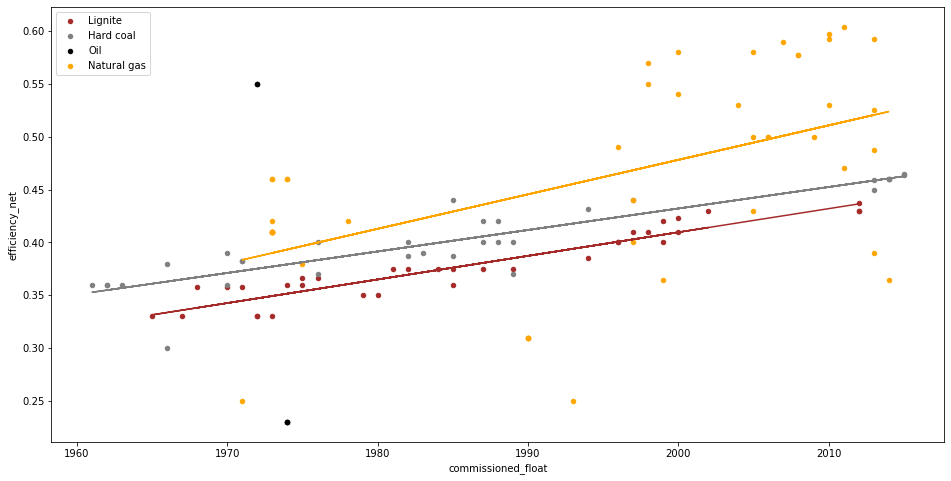

In [175]:
# Plot efficiencies for lignite, coal, oil, and natural gas

fuel_for_plot = ['Lignite', 'Hard coal', 'Oil', 'Natural gas']
col_dict = {'Lignite': 'brown', 'Hard coal': 'grey', 'Oil': 'k', 'Natural gas': 'orange'}

fig, ax = plt.subplots(figsize=(16,8))

for fuels in fuel_for_plot:
     
    sub_df = plantlist_for_efficiency_analysis[plantlist_for_efficiency_analysis.fuel == fuels]
    
    if len(sub_df['efficiency_net']) > 10:
        x = np.array(sub_df['commissioned_float'].astype(int))
        fit = np.polyfit(x, sub_df['efficiency_net'], deg=1)
        ax.plot(x, fit[0]*x + fit[1],  color=col_dict[fuels])
    
    sub_df.plot(ax=ax,
                kind='scatter',
                x='commissioned_float',
                y='efficiency_net',
                c=col_dict[fuels],
                label=fuels)                                                      

### 7.8.2 Efficiencies from literature

Jonas Egerer, Clemens Gerbaulet, Richard Ihlenburg, Friedrich Kunz, Benjamin Reinhard, Christian von Hirschhausen, Alexander Weber, Jens Weibezahn (2014): **Electricity Sector Data for Policy-Relevant Modeling: Data Documentation and Applications to the German and European Electricity Markets**. DIW Data Documentation 72, Berlin, Germany.

#### 7.8.2.1 Import data

For each energy source - technology combination two values are read, to be applied as a linear approximation based on the year of commissioning. Therefore, the efficiency is made up of the efficiency_intercept (the efficiency at "year zero") plus the efficiency_slope multiplied by the year of commissioning.

In [176]:
data_efficiencies_literature = pd.read_csv(os.path.join('input/data/DE','input_efficiency_literature_by_fuel_technology.csv'),
                                     sep=',',  # CSV field separator, default is ','
                                     decimal='.',  # Decimal separator, default is '.')  
                                     encoding='utf8')
#data_efficiencies_literature['technology'] = data_efficiencies_literature['technology'].str.upper()
data_efficiencies_literature = data_efficiencies_literature.set_index(['fuel','technology'])
data_efficiencies_literature

efficiency_intercept  efficiency_slope
fuel               technology                                               
Biomass and biogas Steam turbine                     0.380            0.0000
                   Combustion Engine                -2.358            0.0014
Hard coal          Steam turbine                    -4.575            0.0025
                   Combined cycle                   -8.460            0.0045
Natural gas        Combustion Engine                -2.358            0.0014
                   Combined cycle                   -8.460            0.0045
                   Gas turbine                      -4.820            0.0026
                   hp                                0.950            0.0000
                   ic                                0.380            0.0000
                   Steam turbine                    -1.815            0.0011
Lignite            Steam turbine                    -4.400            0.0024
Oil                Combustion Engine                -2.358            0.0014
                   Gas turbine                      -4.820            0.0026
                   Combined cycle                    0.380            0.0000
                   ic                                0.380            0.0000
                   Steam turbine                    -1.815            0.0011
Nuclear            Steam turbine                     0.330            0.0000
Waste              Gas turbine                       0.330            0.0000
                   Steam turbine                     0.330            0.0000
                   Combined cycle                    0.330            0.0000
Hydro              Pumped storage                    0.750            0.0000
                   Reservoir                         0.800            0.0000
                   Run-of-river                      0.800            0.0000
Other fossil fuels Gas turbine                       0.330            0.0000
                   Combined cycle                    0.330            0.0000
                   Steam turbine                     0.330            0.0000
                   Combustion Engine                -2.358            0.0014

#### 7.8.2.2 Apply efficiency approximation from literature

In [177]:
plantlist = plantlist.join(data_efficiencies_literature,on=['fuel','technology'])
plantlist['efficiency_literature'] = plantlist['efficiency_intercept'] + plantlist['efficiency_slope']*plantlist[['commissioned_float','retrofit_float']].max(axis=1)
plantlist.head()

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,...,country_code,efficiency_net,efficiency_gross,efficiency_comment,date,efficiency_source,source_type,efficiency_intercept,efficiency_slope,efficiency_literature
BNA0005,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT A,1990,shutdown_temporary,Erdgas,...,DE,0.31,NaN,NaN,2015-30-10,https://www.ffe.de/download/berichte/Endberich...,A,-4.82,0.0026,0.354
BNA0006,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT B,1990,shutdown_temporary,Erdgas,...,DE,0.31,NaN,NaN,2015-30-10,https://www.ffe.de/download/berichte/Endberich...,A,-4.82,0.0026,0.354
BNA0007,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT C,1990,shutdown_temporary,Erdgas,...,DE,0.31,NaN,NaN,2015-30-10,https://www.ffe.de/download/berichte/Endberich...,A,-4.82,0.0026,0.354
BNA0008,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT D,1990,shutdown_temporary,Erdgas,...,DE,0.31,NaN,NaN,2015-30-10,https://www.ffe.de/download/berichte/Endberich...,A,-4.82,0.0026,0.354
BNA0010a,Rheinkraftwerk Albbruck-Dogern AG,RADAG,79774,Albbruck,Kraftwerkstrasse 34,Baden-Württemberg,NaN,01.01.1934,operating,Laufwasser,...,DE,NaN,NaN,NaN,NaN,NaN,NaN,0.80,0.0000,0.800


## 7.9 Add geodata and EIC Codes

The locations of power plants have been researched manually, these are now added to the output. Checking was done visually using satellite imagery and other mapping material.

In [178]:
data_plant_locations = pd.read_csv(os.path.join('input/data/DE','input_plant_locations_de.csv'),
                                     sep=',',  # CSV field separator, default is ','
                                     decimal='.',  # Decimal separator, default is '.')  
                                     encoding='utf8')

data_plant_locations = data_plant_locations.set_index('id')

data_plant_locations['lat'] = pd.to_numeric(data_plant_locations['lat'], 
                                            errors='coerce')
data_plant_locations['lon'] = pd.to_numeric(data_plant_locations['lon'], 
                                            errors='coerce')

plantlist = pd.merge(plantlist, 
                     data_plant_locations, 
                     left_index=True, 
                     right_index=True, 
                     how='left')
plantlist.head()

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,...,date,efficiency_source,source_type,efficiency_intercept,efficiency_slope,efficiency_literature,lat,lon,eic_code_plant,eic_code_block
BNA0005,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT A,1990,shutdown_temporary,Erdgas,...,2015-30-10,https://www.ffe.de/download/berichte/Endberich...,A,-4.82,0.0026,0.354,52.58950,13.558652,NaN,NaN
BNA0006,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT B,1990,shutdown_temporary,Erdgas,...,2015-30-10,https://www.ffe.de/download/berichte/Endberich...,A,-4.82,0.0026,0.354,52.58950,13.558652,NaN,NaN
BNA0007,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT C,1990,shutdown_temporary,Erdgas,...,2015-30-10,https://www.ffe.de/download/berichte/Endberich...,A,-4.82,0.0026,0.354,52.58950,13.558652,NaN,NaN
BNA0008,Lausitz Energie Kraftwerke AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT D,1990,shutdown_temporary,Erdgas,...,2015-30-10,https://www.ffe.de/download/berichte/Endberich...,A,-4.82,0.0026,0.354,52.58950,13.558652,NaN,NaN
BNA0010a,Rheinkraftwerk Albbruck-Dogern AG,RADAG,79774,Albbruck,Kraftwerkstrasse 34,Baden-Württemberg,NaN,01.01.1934,operating,Laufwasser,...,NaN,NaN,NaN,0.80,0.0000,0.800,47.58629,8.132070,NaN,NaN


In [179]:
plantlist[plantlist.lat.isnull()]

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,...,date,efficiency_source,source_type,efficiency_intercept,efficiency_slope,efficiency_literature,lat,lon,eic_code_plant,eic_code_block


## 7.10 Allocate energy source levels

To enable a more readable output, the columns 'fuel' is augmented with additional information called 'energy source level'

In [180]:
# read energy source level allocation table
energy_source_level_allocator = pd.read_csv(os.path.join('input', 'energy_source_level_allocator.csv'),
                                     sep=',',  # CSV field separator, default is ','
                                     decimal='.',  # Decimal separator, default is '.')
                                     index_col='fuel',
                                     encoding='utf8')
plantlist = pd.merge(energy_source_level_allocator, plantlist,
                    left_index = True,
                    right_on='fuel',
                    how='outer')

plantlist

,energy_source_level_1,energy_source_level_2,energy_source_level_3,company,name,postcode,city,street,state,block,...,date,efficiency_source,source_type,efficiency_intercept,efficiency_slope,efficiency_literature,lat,lon,eic_code_plant,eic_code_block
BNA0012a,Renewable energy,Bioenergy,Biomass and biogas,Sappi Alfeld GmbH,Werkskraftwerk Sappi Alfeld,31061,Alfeld,Mühlenmarsch 1,Niedersachsen,Turbine 5,...,NaN,NaN,NaN,0.380,0.0000,0.3800,51.984761,9.822831,NaN,NaN
BNA0021,Renewable energy,Bioenergy,Biomass and biogas,Heizkraftwerk Altenstadt GmbH & Co. KG,HKW Altenstadt,86972,Altenstadt,Triebstraße 90,Bayern,NaN,...,NaN,NaN,NaN,0.380,0.0000,0.3800,47.797140,10.858740,NaN,NaN
BNA0027,Renewable energy,Bioenergy,Biomass and biogas,Zellstoff Stendal GmbH,Zellstoff Stendal GmbH,39596,Arneburg,Goldbecker Straße 1,Sachsen-Anhalt,-,...,NaN,NaN,NaN,0.380,0.0000,0.3800,52.727130,12.011150,NaN,NaN
BNA0055,Renewable energy,Bioenergy,Biomass and biogas,Pfleiderer Baruth GmbH,UTB,15837,Baruth/Mark,An der Birkenpfuhlheide 3,Brandenburg,NaN,...,NaN,NaN,NaN,0.380,0.0000,0.3800,52.077780,13.517250,NaN,NaN
BNA0062,Renewable energy,Bioenergy,Biomass and biogas,Sonae Arauco Beeskow GmbH,BHW Beeskow,15848,Beeskow,NaN,Brandenburg,NaN,...,NaN,NaN,NaN,0.380,0.0000,0.3800,52.182690,14.258410,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BNA1867,Other or unspecified energy sources,Waste,NaN,AVG Köln mbH,AVG Köln,50735,Köln,Geestemünder Straße 23,Nordrhein-Westfalen,Turbosatz 2,...,NaN,NaN,NaN,0.330,0.0000,0.3300,50.999620,6.940959,NaN,NaN
BNA0492,NaN,NaN,NaN,RAG Anthrazit Ibbenbüren GmbH,RAG Anthrazit Ibbenbüren GmbH,49477,Ibbenbüren,NaN,Nordrhein-Westfalen,EVA,...,NaN,NaN,NaN,0.330,0.0000,0.3300,52.285880,7.746130,NaN,NaN
BNA0997,NaN,NaN,NaN,STEAG New Energies GmbH,"HKW Fenne, Grubengaskraftwerk",66333,Völklingen-Fenne,NaN,Saarland,Gasmotorenanlage Fenne,...,NaN,NaN,NaN,-2.358,0.0014,0.4462,49.249018,6.879244,NaN,NaN
BNA1864,NaN,NaN,NaN,KÄMMERER Energie GmbH,Turbine 4,49084,Osnabrück,Römereschstrasse 33,Niedersachsen,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,52.294036,8.022962,NaN,NaN


# 8. Define final output

In [181]:

# Merge uba_name_aggregate and uba_name
plantlist.loc[plantlist['uba_name_aggregate'].isnull(), 'uba_name_aggregate'] = plantlist['uba_name'][plantlist['uba_name_aggregate'].isnull()]

# Drop columns not relevant for output
colsToDrop = ['bnetza_id',
              'capacity',
              'uba_name',
              'uba_capacity_original',
              'uba_chp_capacity_original',
              'uba_city',
              'uba_commissioned',
              'uba_company',
              'uba_company_aggregate',
              'uba_fuel',
              'uba_postcode',
              'uba_state',
              'uba_technology',
              'uba_technology_aggregate',
              'retrofit',
              'uba_commissioned_1',
              'uba_commissioned_2',
              'uba_commissioned_3',
              'commissioned_1',
              'commissioned_2',
              'commissioned_3',
              'fuel_basis',
              'fuel_multiple1',
              'fuel_multiple2',
              'efficiency_gross',
              'efficiency_intercept',
              'efficiency_slope',
              'source_type',
              'date'
             ]
plantlist = plantlist.drop(colsToDrop, axis=1)

# Rename columns
plantlist = plantlist.rename(columns={'commissioned': 'commissioned_original',
                                      'commissioned_float': 'commissioned',
                                      'retrofit_float': 'retrofit',
                                      'capacity_float': 'capacity_net_bnetza',
                                      'uba_capacity': 'capacity_gross_uba',
                                      'uba_chp_capacity': 'chp_capacity_uba',
                                      'efficiency_net': 'efficiency_data',
                                      'efficiency_literature': 'efficiency_estimate',
                                      'uba_name_aggregate': 'name_uba',
                                      'name': 'name_bnetza',
                                      'block': 'block_bnetza',
                                      'country_code': 'country',
                                      'fuel': 'energy_source',
                                     })

# Sort columns
columns_sorted = [
                 'name_bnetza',
                 'block_bnetza',
                 'name_uba',
                 'company',
                 'street',
                 'postcode',
                 'city',
                 'state',
                 'country',
                 'capacity_net_bnetza',
                 'capacity_gross_uba',
                 'energy_source',
                 'technology',
                 'chp',
                 'chp_capacity_uba',
                 'commissioned',
                 'commissioned_original',
                 'retrofit',
                 'shutdown',
                 'status',
                 'type',
                 'lat',
                 'lon',
                 'eic_code_plant',
                 'eic_code_block',
                 'efficiency_data',
                 'efficiency_source',
                 'efficiency_estimate',
                 'energy_source_level_1',
                 'energy_source_level_2',
                 'energy_source_level_3',
                 'eeg',
                 'network_node',
                 'voltage',
                 'network_operator',
                 'merge_comment',
                 'comment']
plantlist = plantlist.reindex(columns=columns_sorted)

plantlist.head()

,name_bnetza,block_bnetza,name_uba,company,street,postcode,city,state,country,capacity_net_bnetza,...,efficiency_estimate,energy_source_level_1,energy_source_level_2,energy_source_level_3,eeg,network_node,voltage,network_operator,merge_comment,comment
BNA0012a,Werkskraftwerk Sappi Alfeld,Turbine 5,NaN,Sappi Alfeld GmbH,Mühlenmarsch 1,31061,Alfeld,Niedersachsen,DE,13.0,...,0.38,Renewable energy,Bioenergy,Biomass and biogas,yes,NaN,Mittelspannung (MS),Überlandwerk Leinetal GmbH,NaN,NaN
BNA0021,HKW Altenstadt,NaN,NaN,Heizkraftwerk Altenstadt GmbH & Co. KG,Triebstraße 90,86972,Altenstadt,Bayern,DE,9.8,...,0.38,Renewable energy,Bioenergy,Biomass and biogas,yes,NaN,Mittelspannung (MS),LEW Verteilnetz GmbH,NaN,NaN
BNA0027,Zellstoff Stendal GmbH,-,Arneburg,Zellstoff Stendal GmbH,Goldbecker Straße 1,39596,Arneburg,Sachsen-Anhalt,DE,138.9,...,0.38,Renewable energy,Bioenergy,Biomass and biogas,yes,DE0075603959600000E00000000013559 DE0075603959...,USp. Mittel- / Niederspannung (MS/NS),Infrastrukturbetrieb der Stadt Arneburg,List matching type: Single UBA power plant ass...,NaN
BNA0055,UTB,NaN,NaN,Pfleiderer Baruth GmbH,An der Birkenpfuhlheide 3,15837,Baruth/Mark,Brandenburg,DE,16.0,...,0.38,Renewable energy,Bioenergy,Biomass and biogas,yes,UTB/Eon-edis,Mittelspannung (MS),E.DIS AG,NaN,NaN
BNA0062,BHW Beeskow,NaN,NaN,Sonae Arauco Beeskow GmbH,NaN,15848,Beeskow,Brandenburg,DE,18.3,...,0.38,Renewable energy,Bioenergy,Biomass and biogas,yes,Umspannwerk Beeskow der E.DIS AG,Hochspannung (HS),E.DIS AG,NaN,NaN


## 8.1 Round values

In [182]:
# Round capacity values as well as the efficiency estimate to five decimals-
plantlist.capacity_net_bnetza = plantlist.capacity_net_bnetza.round(decimals=5)
plantlist.capacity_gross_uba = plantlist.capacity_gross_uba.round(decimals=5)  
plantlist.efficiency_estimate = plantlist.efficiency_estimate.round(decimals=5)

## 8.2 Verification

### 8.2.1 Capacities by plant status

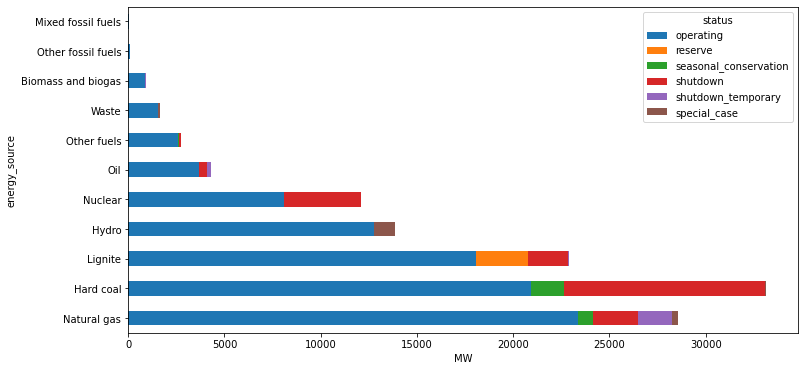

In [183]:
pivot_status_capacity = pd.pivot_table(
                        plantlist, 
                        values='capacity_net_bnetza',
                        columns='status',
                        index='energy_source', 
                        aggfunc=np.sum
                        )
pivot_status_capacity.sort_values(by='operating', inplace=True, ascending=0)
pivot_status_capacity_plot=pivot_status_capacity.plot(kind='barh', 
                                                      stacked=True,
                                                      legend=True, 
                                                      figsize=(12, 6))
pivot_status_capacity_plot.set_xlabel("MW")
pivot_status_capacity_plot

### 8.2.2 Power plant age

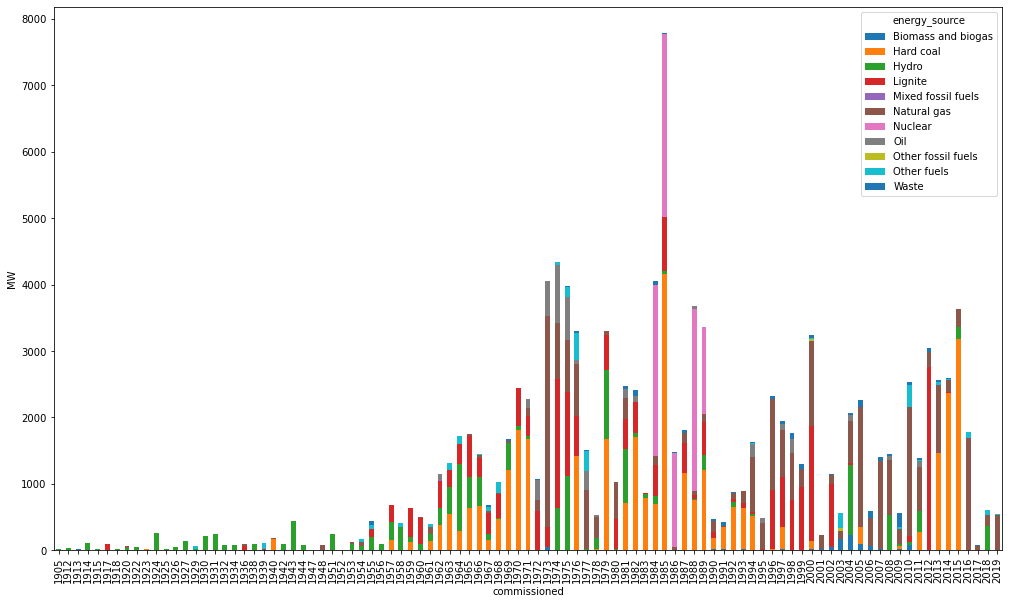

In [184]:
plantlist_filtered = plantlist  
pivot_age_capacity = pd.pivot_table(
                        plantlist_filtered, 
                        values='capacity_net_bnetza',
                        columns='energy_source',
                        index='commissioned', 
                        aggfunc=np.sum,
                        dropna=True
                        )

pivot_age_capacity_plot=pivot_age_capacity.plot(kind='bar', 
                                                stacked=True,
                                                legend=True, 
                                                figsize=(17, 10))
pivot_age_capacity_plot.set_ylabel("MW")

xaxis_labels = pivot_age_capacity.index.astype(int)
pivot_age_capacity_plot.set_xticklabels(xaxis_labels)


pivot_age_capacity_plot

### 8.2.3 Block size vs year of commissioning

This chart is suitable to check outliers of commissioning years and block sizes. 
In theory, there should be no unexpected values, e.g. all commissioning years should be greater than 1900. 
Block sizes above 2000 MW are also unlikely.

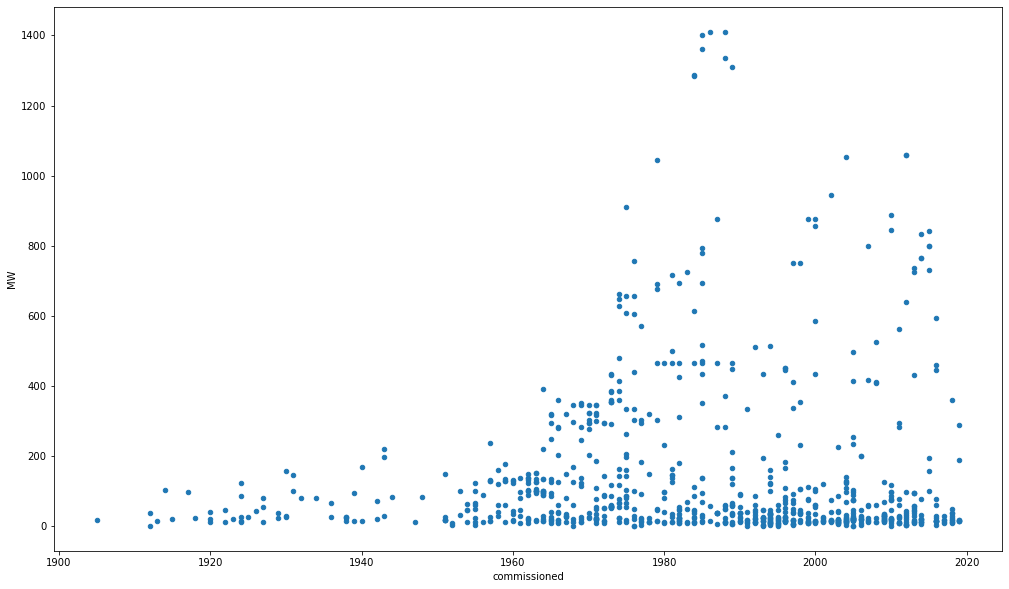

In [185]:
plantlist_for_plot = plantlist.copy(deep=True)
plantlist_for_plot['capacity_float'] = pd.to_numeric(plantlist_for_plot['capacity_net_bnetza'], 
                                                     errors='coerce')
plantlist_for_plot['commissioned_float'] = pd.to_numeric(plantlist_for_plot['commissioned'], 
                                                         errors='coerce')

age_capacity_plot = plantlist_for_plot.plot(kind='scatter', x='commissioned_float', y='capacity_float', figsize=(17, 10))
age_capacity_plot.set_xlabel("commissioned")
age_capacity_plot.set_ylabel("MW")

age_capacity_plot

## 8.3 Logical checks

### 8.3.1 Every power plant needs a capacity

List all entries with zero capacity.

In [186]:
plantlist[plantlist.capacity_net_bnetza == 0]

,name_bnetza,block_bnetza,name_uba,company,street,postcode,city,state,country,capacity_net_bnetza,...,efficiency_estimate,energy_source_level_1,energy_source_level_2,energy_source_level_3,eeg,network_node,voltage,network_operator,merge_comment,comment
BNA0490a,Goldenberg,F,NaN,RWE Power AG,NaN,50354,Hürth,Nordrhein-Westfalen,DE,0.0,...,0.3832,Fossil fuels,Lignite,NaN,no,Knapsack,Hochspannung (HS),Westnetz GmbH,NaN,NaN


### 8.3.2 Commissioning Dates

In [187]:
#Show all Plants with commisioning dates below 1900 
plantlist[plantlist['commissioned'] <= 1900]

,name_bnetza,block_bnetza,name_uba,company,street,postcode,city,state,country,capacity_net_bnetza,...,efficiency_estimate,energy_source_level_1,energy_source_level_2,energy_source_level_3,eeg,network_node,voltage,network_operator,merge_comment,comment


In [188]:
# Show all Plants with invalid commisioning dates
plantlist[plantlist['commissioned'].isnull()]

,name_bnetza,block_bnetza,name_uba,company,street,postcode,city,state,country,capacity_net_bnetza,...,efficiency_estimate,energy_source_level_1,energy_source_level_2,energy_source_level_3,eeg,network_node,voltage,network_operator,merge_comment,comment
BNA0059a,HKW Kassel,Turbine 1,NaN,Volkswagen AG,NaN,34225,Baunatal,Hessen,DE,12.20,...,NaN,Fossil fuels,Natural gas,NaN,no,Anlage A,Mittelspannung (MS),VW Kraftwerk GmbH,NaN,NaN
BNA0080,Lichterfelde,Lichterfelde 2,NaN,Vattenfall Europe Wärme AG,Ostpreußendamm 61,12207,Berlin,Berlin,DE,144.00,...,NaN,Fossil fuels,Natural gas,NaN,no,Lichterfelde,Hochspannung (HS),Stromnetz Berlin GmbH,List matching type: Single UBA power plant ass...,NaN
BNA0118,Heizkraftwerk Süd,Heizkraftwerk Süd,NaN,Energie- und Wasserversorgung Bonn/Rhein-Sieg ...,NaN,53121,Bonn,Nordrhein-Westfalen,DE,14.40,...,NaN,Fossil fuels,Natural gas,NaN,no,Umspannanlage Kessenich,10,Bonn Netz GmbH,NaN,NaN
BNA0140,KW Hastedt,Block 14,NaN,swb Erzeugung GmbH & Co. KG,Hastedter Osterdeich 255,28207,Bremen,Bremen,DE,155.00,...,NaN,Fossil fuels,Natural gas,NaN,no,DE0072032820700000000000000232556,Hochspannung (HS),Wesernetz Bremen GmbH,NaN,NaN
BNA0288,HKW Niederrad,Block 2,NaN,Mainova AG,Lyoner Straße 9,60528,Frankfurt am Main,Hessen,DE,56.00,...,NaN,Fossil fuels,Natural gas,NaN,no,UW Goldsteinstraße,Hochspannung (HS),NRM Netzdienste Rhein-Main GmbH,List matching type: UBA capacity distributed p...,NaN
BNA0681,Freimann GT 1,1,NaN,SWM Services GmbH,NaN,80807,München,Bayern,DE,80.00,...,NaN,Fossil fuels,Natural gas,NaN,no,UW Freimann,Hochspannung (HS),SWM Infrastruktur GmbH,NaN,NaN
BNA0682,Freimann GT 2,2,NaN,SWM Services GmbH,NaN,80807,München,Bayern,DE,80.00,...,NaN,Fossil fuels,Natural gas,NaN,no,UW Freimann,Hochspannung (HS),SWM Infrastruktur GmbH,NaN,NaN
BNA0735,Thyrow,GT F,NaN,Lausitz Energie Kraftwerke AG,NaN,15806,Nunsdorf,Brandenburg,DE,37.50,...,NaN,Fossil fuels,Natural gas,NaN,no,Thyrow,Hochspannung (HS),50Hertz Transmission GmbH,List matching type: UBA capacity distributed p...,NaN
BNA0736,Thyrow,GT G,NaN,Lausitz Energie Kraftwerke AG,NaN,15806,Nunsdorf,Brandenburg,DE,37.50,...,NaN,Fossil fuels,Natural gas,NaN,no,Thyrow,Hochspannung (HS),50Hertz Transmission GmbH,List matching type: UBA capacity distributed p...,NaN
BNA0737,Thyrow,GT H,NaN,Lausitz Energie Kraftwerke AG,NaN,15806,Nunsdorf,Brandenburg,DE,37.50,...,NaN,Fossil fuels,Natural gas,NaN,no,Thyrow,Hochspannung (HS),50Hertz Transmission GmbH,List matching type: UBA capacity distributed p...,NaN


### 8.3.3 Compare UBA and BNetzA data

#### 8.3.3.2 Compare Installed capacities

In [189]:
# TODO: improve this comparison, it creates many false positives

capacitycomparison = pd.DataFrame(plantlist.capacity_net_bnetza / plantlist.capacity_gross_uba)
capacitycomparison['Name'] = plantlist.name_bnetza
capacitycomparison['Block'] = plantlist.block_bnetza
capacitycomparison['BnetzaCapacity'] = plantlist.capacity_net_bnetza
capacitycomparison['UBACapacity'] = plantlist.capacity_gross_uba
capacitycomparison.dropna(inplace=True)
capacitycomparison.sort_values(by=0)

,0,Name,Block,BnetzaCapacity,UBACapacity
BNA0859,0.208333,Rheinkraftwerk Ryburg-Schwörstadt,Ryburg-Schwörstadt,30.00,144.00000
BNA0835,0.402586,KW Rheinfelden,KW Rheinfelden,46.70,116.00000
BNA0364,0.493642,Jochenstein,Jochenstein,66.00,133.70000
BNA0444,0.627273,Wintershall,Wintershall,69.00,110.00000
BNA0616b,0.688976,Kraftwerk Nord,"S 300 VT 1, VT 2, NT 7",87.50,127.00000
...,...,...,...,...,...
BNA0660,1.481960,Kraftwerk I,Block 4,55.56,37.49088
BNA0662b,1.481961,Kraftwerk I,Dampfwirtschaft (6 Einzelturbinen),169.32,114.25405
BNA0662a,1.481961,Kraftwerk I,Block 5,68.40,46.15507
BNA0350,3.969811,Goldisthal,PSS A,1052.00,265.00000


# 9. Result export

Write the results to file

In [190]:
output_path = 'output'

plantlist.to_csv(
    os.path.join(output_path, 'conventional_power_plants_DE.csv'),
    encoding='utf-8', index_label='id'
)

plantlist.to_excel(
    os.path.join(output_path, 'conventional_power_plants_DE.xlsx'),
    sheet_name='plants', index_label='id'
)

plantlist.to_sql(
    'conventional_power_plants_DE',
    sqlite3.connect(os.path.join(output_path ,'conventional_power_plants.sqlite')),
    if_exists="replace", index_label='id'
)